# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 22)
CPU times: user 118 ms, sys: 18.2 ms, total: 136 ms
Wall time: 137 ms


,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,Card_Merchnum_Zip_avg_14,Card_Merchnum_Zip_max_60,...,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,7.24,3.62,7.24,3.62,3.62,3.62,3.62,...,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_30',
 'card_state_total_3',
 'Merchnum_desc_total_1',
 'Card_Merchdesc_Zip_max_60',
 'card_state_total_0',
 'Card_Merchdesc_max_60',
 'Card_Merchnum_desc_max_60',
 'Card_Merchnum_Zip_avg_14',
 'Card_Merchnum_Zip_max_60',
 'card_merch_avg_14',
 'card_merch_max_60',
 'state_des_total_1',
 'Merchnum_desc_State_total_7',
 'Merchnum_desc_total_7',
 'Merchnum_desc_State_total_1',
 'card_zip3_total_60',
 'Card_Merchnum_Zip_total_14',
 'Card_Merchnum_Zip_total_30',
 'Merchnum_desc_State_total_3']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,...,card_merch_avg_14,card_merch_max_60,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,7.24,3.62,7.24,3.62,3.62,...,3.62,3.62,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24


In [5]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [6]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,Card_Merchnum_Zip_avg_14,Card_Merchnum_Zip_max_60,card_merch_avg_14,card_merch_max_60,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.00000,96397.000000,96397.000000
mean,770.021380,592.200703,738.626206,1042.586186,551.294487,554.112357,552.096524,542.051339,401.883217,547.313490,401.929346,547.659436,1083.361925,2253.624215,2254.195777,1042.434341,1636.302993,769.30085,921.828129,1416.169547
std,4168.237132,1139.448020,4120.005523,4347.915213,1104.335602,2640.532674,1104.598654,1090.106618,790.448896,1089.597777,790.422343,1089.723489,4419.118154,6299.406923,6299.486230,4347.912314,5128.331816,4167.86382,4298.476488,5146.703199
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.010000
25%,77.000000,69.450000,65.560000,81.600000,52.560000,49.140000,52.770000,50.450000,39.990000,59.000000,39.990000,59.000000,84.950000,130.210000,130.350000,81.600000,166.430000,76.99000,93.610000,99.950000
50%,236.950000,256.000000,217.000000,286.550000,223.560000,169.000000,224.300000,217.000000,157.000000,220.080000,157.090000,220.450000,295.000000,502.310000,502.820000,286.480000,518.000000,236.55000,289.200000,355.010000
75%,676.900000,718.710000,659.990000,992.400000,658.000000,515.000000,659.340000,645.000000,452.750000,649.000000,452.940000,649.990000,1019.800000,2136.460000,2137.510000,991.800000,1518.000000,676.25000,823.160000,1329.840000
max,306633.410000,47900.000000,306633.410000,306633.410000,47900.000000,217467.180000,47900.000000,47900.000000,28392.840000,47900.000000,28392.840000,47900.000000,306633.410000,313984.550000,313984.550000,306633.410000,306633.410000,306633.41000,306633.410000,307302.580000


In [7]:
# normalize the variables

X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [8]:
# use this to cap variables. For some problems it helps
# Clip = 5

In [9]:
# push in any outlier values, then rescale
# X.clip(-1*Clip,Clip,inplace=True)
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,Card_Merchnum_Zip_avg_14,Card_Merchnum_Zip_max_60,card_merch_avg_14,card_merch_max_60,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-6.077446e-16,7.910710e-15,-8.251160e-16,-4.536170e-16,-3.151657e-16,-1.658189e-15,3.751579e-15,1.608422e-15,9.591367e-15,8.976462e-15,1.007388e-14,1.030284e-14,3.058420e-17,3.736421e-15,3.567896e-15,5.444547e-16,-1.870542e-15,-6.693373e-16,-1.791051e-16,7.197728e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847331e-01,-5.197172e-01,-1.792755e-01,-2.397876e-01,-4.992001e-01,-2.098449e-01,-4.998073e-01,-4.972370e-01,-5.084114e-01,-5.022986e-01,-5.084868e-01,-5.025582e-01,-2.451512e-01,-3.577502e-01,-3.578364e-01,-2.397528e-01,-3.190693e-01,-1.845768e-01,-2.144523e-01,-2.751586e-01
25%,-1.662625e-01,-4.587754e-01,-1.633654e-01,-2.210223e-01,-4.516150e-01,-1.912388e-01,-4.520434e-01,-4.509663e-01,-4.578325e-01,-4.481594e-01,-4.579063e-01,-4.484252e-01,-2.259301e-01,-3.370816e-01,-3.371459e-01,-2.209875e-01,-2.866182e-01,-1.661069e-01,-1.926771e-01,-2.557403e-01
50%,-1.278889e-01,-2.950558e-01,-1.266081e-01,-1.738848e-01,-2.967707e-01,-1.458465e-01,-2.967562e-01,-2.981831e-01,-3.098027e-01,-3.003250e-01,-3.097576e-01,-3.002683e-01,-1.783980e-01,-2.780126e-01,-2.780188e-01,-1.738661e-01,-2.180637e-01,-1.278235e-01,-1.471750e-01,-2.061824e-01
75%,-2.234071e-02,1.110268e-01,-1.908643e-02,-1.154259e-02,9.662417e-02,-1.481230e-02,9.708818e-02,9.443908e-02,6.435177e-02,9.332481e-02,6.453595e-02,9.390507e-02,-1.438340e-02,-1.859925e-02,-1.852306e-02,-1.164567e-02,-2.306851e-02,-2.232579e-02,-2.295421e-02,-1.677376e-02
max,7.337956e+01,4.151817e+01,7.424621e+01,7.028445e+01,4.287529e+01,8.214747e+01,4.286435e+01,4.344341e+01,3.541147e+01,4.345887e+01,3.541260e+01,4.345354e+01,6.914277e+01,4.948576e+01,4.948504e+01,7.028453e+01,5.947297e+01,7.338630e+01,7.112092e+01,5.943347e+01


In [10]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
# oot_recnum=84300
oot_recnum = 83970
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    179
dtype: int64

In [11]:
X_trntst.shape

(83970, 20)

In [12]:
X_trntst.head()

,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,Card_Merchnum_Zip_avg_14,Card_Merchnum_Zip_max_60,card_merch_avg_14,card_merch_max_60,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3
0,-0.183867,-0.516549,-0.178399,-0.238957,-0.495931,-0.208478,-0.496539,-0.493925,-0.503844,-0.498985,-0.503920,-0.499245,-0.244334,-0.357177,-0.357263,-0.238923,-0.318365,-0.183711,-0.213612,-0.274457
1,-0.177198,-0.492151,-0.171652,-0.232563,-0.470758,-0.197950,-0.471372,-0.468423,-0.468674,-0.473471,-0.468749,-0.473734,-0.238043,-0.352764,-0.352850,-0.232529,-0.312944,-0.177041,-0.207145,-0.269056
2,-0.141914,-0.363080,-0.135955,-0.198738,-0.337583,-0.142252,-0.338228,-0.333510,-0.282616,-0.338495,-0.282683,-0.338773,-0.204763,-0.329417,-0.329504,-0.198703,-0.284267,-0.141754,-0.172931,-0.240480
3,-0.183867,-0.516549,-0.178399,-0.238957,-0.495931,-0.208478,-0.496539,-0.493925,-0.503844,-0.498985,-0.503920,-0.499245,-0.244334,-0.357177,-0.357263,-0.238923,-0.318365,-0.183711,-0.213612,-0.274457
4,-0.182999,-0.516549,-0.177521,-0.238125,-0.495931,-0.207107,-0.496539,-0.493925,-0.503844,-0.498985,-0.503920,-0.499245,-0.243515,-0.356602,-0.356689,-0.238090,-0.317659,-0.182842,-0.212770,-0.273754


## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [13]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [14]:
Modeling_output = pd.DataFrame()
counter = 0
model_counter = 0

In [15]:
def log_reg(penalty='l2', C=1.0, l1_ratio=None, max_iter=100, solver='lbfgs'):
# Logistic regression
    logreg_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0

    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = LogisticRegression(penalty=penalty, C=C, l1_ratio=l1_ratio, max_iter=max_iter,solver=solver)
        print(model.get_params())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        logreg_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return logreg_output
    

In [16]:
Modeling_output = Modeling_output.append(log_reg(solver='saga', max_iter=2000, penalty='l2', C=1.0))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0 0.6219312602291326 0.6654275092936803 0.3407821229050279
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
1 0.6434231378763867 0.6345381526104418 0.3407821229050279
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
2 0.6333333333333333 0.6428571428571429 0.340782122

/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/2297458582.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(log_reg(solver='saga', max_iter=2000, penalty='l2', C=1.0))


In [17]:
Modeling_output

,Model,Trn,Tst,OOT
0,log reg,0.621931,0.665428,0.340782
1,log reg,0.643423,0.634538,0.340782
2,log reg,0.633333,0.642857,0.340782
3,log reg,0.654036,0.600733,0.340782
4,log reg,0.650246,0.608856,0.340782
5,log reg,0.632721,0.669039,0.340782
6,log reg,0.618812,0.620438,0.335196
7,log reg,0.621406,0.653543,0.340782
8,log reg,0.630225,0.604651,0.335196
9,log reg,0.633117,0.655303,0.335196


In [18]:
%%time
# Single DT
def dt(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1):
    dt_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0

    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
        print(model.get_params())
        
        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        dt_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return dt_output

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 4.05 µs


In [19]:
Modeling_output = Modeling_output.append(dt(splitter='best', max_depth=60, min_samples_split=100, min_samples_leaf=20))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 60, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
0 0.9042207792207793 0.803030303030303 0.4748603351955307
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 60, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
1 0.8985270049099836 0.7806691449814126 0.44692737430167595
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 60, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
2 0.896774193548387 0.8153846153846154 0.4

/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/3269881378.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(dt(splitter='best', max_depth=60, min_samples_split=100, min_samples_leaf=20))


In [20]:
%%time
# RF
def rf(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1):
    rf_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0
    
    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        print(model.get_params())
        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        rf_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return rf_output

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


In [21]:
Modeling_output = Modeling_output.append(rf(n_estimators=50, max_depth=15, min_samples_split=1000, min_samples_leaf=400))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 400, 'min_samples_split': 1000, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0 0.6603174603174603 0.708 0.45251396648044695
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 400, 'min_samples_split': 1000, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
1 0.6473429951690821 0.6988416988416989 0.46368715083798884
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_

/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/1079223682.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(rf(n_estimators=50, max_depth=15, min_samples_split=1000, min_samples_leaf=400))


In [22]:
%%time
# LGBM

def lgbm(n_estimators=100, num_leaves=31, learning_rate=0.1, max_depth=-1, min_child_samples=20):
    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    
    lgbm_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0
    
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = lgb.LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, learning_rate=learning_rate, max_depth=max_depth, min_child_samples=min_child_samples)
        print(model.get_params())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        lgbm_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return lgbm_output

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


In [23]:
Modeling_output = Modeling_output.append(lgbm(n_estimators=50, num_leaves=30, learning_rate=0.5, max_depth=15, min_child_samples=200))

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.5, 'max_depth': 15, 'min_child_samples': 200, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 30, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0 0.3799682034976153 0.250996015936255 0.21787709497206703
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.5, 'max_depth': 15, 'min_child_samples': 200, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 30, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
1 0.4692556634304207 0.26717557251908397 0.2122905027932961
{'boosting_type':

/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/2547136002.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(lgbm(n_estimators=50, num_leaves=30, learning_rate=0.5, max_depth=15, min_child_samples=200))


In [24]:
%%time
# NN

def nn(hidden_layer_sizes=100, activation='relu', alpha=0.0001, learning_rate='constant', max_iter=200):
    
    mlp_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0

    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):  
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, learning_rate=learning_rate, max_iter=max_iter)
        print(model.get_params())
        
        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        mlp_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return mlp_output

CPU times: user 8 µs, sys: 6 µs, total: 14 µs
Wall time: 4.05 µs


In [25]:
Modeling_output = Modeling_output.append(nn(hidden_layer_sizes=200, alpha=0.001, learning_rate='adaptive', max_iter=400))

{'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0 0.8394039735099338 0.7934782608695652 0.46368715083798884
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, '

/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/1766353720.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(nn(hidden_layer_sizes=200, alpha=0.001, learning_rate='adaptive', max_iter=400))


In [26]:
%%time
# Catboost

def catboost(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, loss_function=None, bootstrap_type='Bayesian'):
    
    cat_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0
    
    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):  
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = CatBoostClassifier(verbose=0, iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, loss_function=loss_function, bootstrap_type=bootstrap_type)
        #print(model.get_all_params())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        cat_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return cat_output

CPU times: user 2 µs, sys: 7 µs, total: 9 µs
Wall time: 4.05 µs


In [27]:
Modeling_output = Modeling_output.append(catboost(iterations=1000, learning_rate=0.01, depth=12, l2_leaf_reg=24, bootstrap_type='Bayesian'))

0 0.8462757527733756 0.8353413654618473 0.4860335195530726
1 0.8509933774834437 0.8152173913043478 0.547486033519553
2 0.8608837970540099 0.7992565055762082 0.4860335195530726
3 0.8469055374592834 0.8421052631578947 0.4860335195530726
4 0.8519685039370078 0.7795918367346939 0.4860335195530726
5 0.8632619439868204 0.7765567765567766 0.4972067039106145
6 0.8681135225375626 0.800711743772242 0.5195530726256983
7 0.8583473861720068 0.8153310104529616 0.547486033519553
8 0.8589341692789969 0.8016528925619835 0.5251396648044693
9 0.8499184339314845 0.8277153558052435 0.5139664804469274
trn    0.855560
tst    0.809348
oot    0.509497
dtype: float64


/var/folders/gl/s_1pz2z130g9ct6hvptjf5fh0000gn/T/ipykernel_66373/1574592706.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output = Modeling_output.append(catboost(iterations=1000, learning_rate=0.01, depth=12, l2_leaf_reg=24, bootstrap_type='Bayesian'))


In [28]:
def xgboost(learning_rate=0.3, booster='gbtree', max_depth=6, reg_lambda=1, reg_alpha=0):
    
    xgb_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(10))
    counter = 0
    model_counter = 0    
    
    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):  
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = xgb.XGBClassifier(learning_rate=learning_rate, booster=booster, max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=reg_alpha)
        #print(model.get_all_params())
        
        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        xgb_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    return xgb_output

In [29]:
xgboost(learning_rate=0.05, booster='dart', max_depth=6, reg_lambda=1, reg_alpha=0.5)

0 0.8878048780487805 0.8301886792452831 0.4748603351955307
1 0.9024 0.8627450980392157 0.5307262569832403
2 0.9010989010989011 0.831275720164609 0.4860335195530726
3 0.8920265780730897 0.8165467625899281 0.4972067039106145
4 0.9018003273322422 0.8029739776951673 0.4972067039106145
5 0.9096774193548387 0.823076923076923 0.547486033519553
6 0.8819672131147541 0.8777777777777778 0.5139664804469274
7 0.9022801302931596 0.8308270676691729 0.5195530726256983
8 0.8876582278481012 0.8508064516129032 0.49162011173184356
9 0.8915470494417863 0.8537549407114624 0.48044692737430167
trn    0.895826
tst    0.837997
oot    0.503911
dtype: float64


,Model,Trn,Tst,OOT
0,XGB,0.887805,0.830189,0.47486
1,XGB,0.9024,0.862745,0.530726
2,XGB,0.901099,0.831276,0.486034
3,XGB,0.892027,0.816547,0.497207
4,XGB,0.9018,0.802974,0.497207
5,XGB,0.909677,0.823077,0.547486
6,XGB,0.881967,0.877778,0.513966
7,XGB,0.90228,0.830827,0.519553
8,XGB,0.887658,0.850806,0.49162
9,XGB,0.891547,0.853755,0.480447


## Model comparison plots

In [30]:
best_models = pd.DataFrame(columns=['Model','Trn','Tst','OOT'])
best_models.head()

,Model,Trn,Tst,OOT


In [31]:
log_out = log_reg(solver='lbfgs', max_iter=500, penalty='l2', C=1.0)
log_out

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0 0.6557377049180327 0.6444444444444445 0.3407821229050279
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
1 0.6299342105263158 0.6727941176470589 0.3016759776536313
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
2 0.6357723577235772 0.6113207547169811 0.340782122

,Model,Trn,Tst,OOT
0,log reg,0.655738,0.644444,0.340782
1,log reg,0.629934,0.672794,0.301676
2,log reg,0.635772,0.611321,0.340782
3,log reg,0.642743,0.70751,0.312849
4,log reg,0.628059,0.617978,0.307263
5,log reg,0.64,0.631373,0.340782
6,log reg,0.652733,0.643411,0.301676
7,log reg,0.634146,0.686792,0.340782
8,log reg,0.6407,0.657371,0.340782
9,log reg,0.648425,0.581227,0.335196


In [32]:
best_models = pd.concat([best_models, log_out], ignore_index=True)
best_models

,Model,Trn,Tst,OOT
0,log reg,0.655738,0.644444,0.340782
1,log reg,0.629934,0.672794,0.301676
2,log reg,0.635772,0.611321,0.340782
3,log reg,0.642743,0.70751,0.312849
4,log reg,0.628059,0.617978,0.307263
5,log reg,0.64,0.631373,0.340782
6,log reg,0.652733,0.643411,0.301676
7,log reg,0.634146,0.686792,0.340782
8,log reg,0.6407,0.657371,0.340782
9,log reg,0.648425,0.581227,0.335196


In [33]:
best_models_1 = best_models.copy(deep=True)

In [34]:
dt_out = dt(splitter='best', max_depth=40, min_samples_split=500, min_samples_leaf=100)
dt_out

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
0 0.7916018662519441 0.70042194092827 0.5642458100558659
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
1 0.7784911717495987 0.7431906614785992 0.5642458100558659
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100, 'min_samples_split': 500, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
2 0.7586776859504132 0.7709090909090909 0

,Model,Trn,Tst,OOT
0,DT,0.791602,0.700422,0.564246
1,DT,0.778491,0.743191,0.564246
2,DT,0.758678,0.770909,0.553073
3,DT,0.761194,0.783394,0.541899
4,DT,0.751678,0.725352,0.553073
5,DT,0.765494,0.706714,0.541899
6,DT,0.77371,0.72043,0.558659
7,DT,0.766562,0.743902,0.553073
8,DT,0.763285,0.756757,0.558659
9,DT,0.771475,0.730038,0.581006


In [35]:
best_models = pd.concat([best_models, dt_out], ignore_index=True)

In [36]:
best_models

,Model,Trn,Tst,OOT
0,log reg,0.655738,0.644444,0.340782
1,log reg,0.629934,0.672794,0.301676
2,log reg,0.635772,0.611321,0.340782
3,log reg,0.642743,0.70751,0.312849
4,log reg,0.628059,0.617978,0.307263
5,log reg,0.64,0.631373,0.340782
6,log reg,0.652733,0.643411,0.301676
7,log reg,0.634146,0.686792,0.340782
8,log reg,0.6407,0.657371,0.340782
9,log reg,0.648425,0.581227,0.335196


In [37]:
rf_out = rf(n_estimators=150, max_depth=50, min_samples_split=200, min_samples_leaf=50)
rf_out

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 50, 'min_samples_split': 200, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0 0.8249594813614263 0.7870722433460076 0.5698324022346368
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 50, 'min_samples_split': 200, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
1 0.8314049586776859 0.76 0.5586592178770949
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_featu

,Model,Trn,Tst,OOT
0,RF,0.824959,0.787072,0.569832
1,RF,0.831405,0.76,0.558659
2,RF,0.836478,0.82377,0.569832
3,RF,0.83622,0.755102,0.569832
4,RF,0.825321,0.78125,0.569832
5,RF,0.848185,0.773723,0.569832
6,RF,0.856427,0.765125,0.564246
7,RF,0.841935,0.796154,0.569832
8,RF,0.84058,0.818533,0.569832
9,RF,0.835749,0.814672,0.569832


In [38]:
best_models = pd.concat([best_models, rf_out], ignore_index=True)
best_models

,Model,Trn,Tst,OOT
0,log reg,0.655738,0.644444,0.340782
1,log reg,0.629934,0.672794,0.301676
2,log reg,0.635772,0.611321,0.340782
3,log reg,0.642743,0.70751,0.312849
4,log reg,0.628059,0.617978,0.307263
5,log reg,0.64,0.631373,0.340782
6,log reg,0.652733,0.643411,0.301676
7,log reg,0.634146,0.686792,0.340782
8,log reg,0.6407,0.657371,0.340782
9,log reg,0.648425,0.581227,0.335196


In [39]:
lgbm_out = lgbm(n_estimators=35, num_leaves=25, learning_rate=0.1, max_depth=15, min_child_samples=300)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 300, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 35, 'n_jobs': -1, 'num_leaves': 25, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0 0.9067524115755627 0.8023255813953488 0.49162011173184356
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 300, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 35, 'n_jobs': -1, 'num_leaves': 25, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
1 0.8915470494417863 0.841897233201581 0.5083798882681564
{'boosting_type': 

In [40]:
best_models = pd.concat([best_models, lgbm_out], ignore_index=True)

In [41]:
nn_out = nn(hidden_layer_sizes=100, activation='relu', alpha=0.001, learning_rate='constant', max_iter=400)

{'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0 0.8252427184466019 0.7862595419847328 0.41899441340782123
{'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, '

In [42]:
best_models = pd.concat([best_models, nn_out], ignore_index=True)

In [43]:
cat_out = catboost(iterations=1000, learning_rate=0.01, depth=12, l2_leaf_reg=10, bootstrap_type='Bayesian')

0 0.8836833602584814 0.8275862068965517 0.5027932960893855
1 0.8903436988543372 0.8698884758364313 0.5642458100558659
2 0.8801313628899836 0.8966789667896679 0.5139664804469274
3 0.8922829581993569 0.8217054263565892 0.5027932960893855
4 0.8967851099830795 0.8442906574394463 0.4972067039106145
5 0.905511811023622 0.8204081632653061 0.5027932960893855
6 0.8912337662337663 0.8446969696969697 0.5027932960893855
7 0.8829113924050633 0.8508064516129032 0.5027932960893855
8 0.8946515397082658 0.8098859315589354 0.5307262569832403
9 0.8920265780730897 0.8237410071942446 0.5754189944134078
trn    0.890956
tst    0.840969
oot    0.519553
dtype: float64


In [44]:
best_models = pd.concat([best_models, cat_out], ignore_index=True)

In [45]:
xg_out = xgboost(learning_rate=0.05, booster='dart', max_depth=6, reg_lambda=1, reg_alpha=0.5)
xg_out

0 0.9033816425120773 0.8223938223938224 0.40782122905027934
1 0.9063004846526656 0.8084291187739464 0.5363128491620112
2 0.9031746031746032 0.816 0.5251396648044693
3 0.8898026315789473 0.8492647058823529 0.5139664804469274
4 0.9120521172638436 0.8308270676691729 0.5027932960893855
5 0.9077181208053692 0.8415492957746479 0.49162011173184356
6 0.901453957996769 0.8505747126436781 0.5083798882681564
7 0.9047619047619048 0.7822878228782287 0.5195530726256983
8 0.9118110236220472 0.8204081632653061 0.5083798882681564
9 0.8928 0.8117647058823529 0.5027932960893855
trn    0.903326
tst    0.823350
oot    0.501676
dtype: float64


,Model,Trn,Tst,OOT
0,XGB,0.903382,0.822394,0.407821
1,XGB,0.9063,0.808429,0.536313
2,XGB,0.903175,0.816,0.52514
3,XGB,0.889803,0.849265,0.513966
4,XGB,0.912052,0.830827,0.502793
5,XGB,0.907718,0.841549,0.49162
6,XGB,0.901454,0.850575,0.50838
7,XGB,0.904762,0.782288,0.519553
8,XGB,0.911811,0.820408,0.50838
9,XGB,0.8928,0.811765,0.502793


In [46]:
best_models = pd.concat([best_models, xg_out], ignore_index=True)

In [47]:
best_models.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.655738,0.644444,0.340782
1,log reg,0.629934,0.672794,0.301676
2,log reg,0.635772,0.611321,0.340782
3,log reg,0.642743,0.70751,0.312849
4,log reg,0.628059,0.617978,0.307263
5,log reg,0.64,0.631373,0.340782
6,log reg,0.652733,0.643411,0.301676
7,log reg,0.634146,0.686792,0.340782
8,log reg,0.6407,0.657371,0.340782
9,log reg,0.648425,0.581227,0.335196


In [48]:
best_models.shape

(70, 4)

In [49]:
best_models_unpivot = best_models.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
best_models_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.655738
1,log reg,Trn,0.629934
2,log reg,Trn,0.635772
3,log reg,Trn,0.642743
4,log reg,Trn,0.628059


In [50]:
best_models_compare = best_models_unpivot[(best_models_unpivot['Type']=='Trn') | (best_models_unpivot['Type']=='Tst') | (best_models_unpivot['Type']=='OOT')]
best_models_compare.head()

,Model,Type,Value
0,log reg,Trn,0.655738
1,log reg,Trn,0.629934
2,log reg,Trn,0.635772
3,log reg,Trn,0.642743
4,log reg,Trn,0.628059


In [51]:
output = best_models.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.768217  0.011262  0.738111  0.026833  0.556983  0.011494
LGBM       0.902791  0.005845  0.840008  0.020297  0.525698  0.021468
NN         0.818855  0.026415  0.771480  0.021759  0.484358  0.032793
RF         0.837726  0.009716  0.787540  0.025005  0.568156  0.003771
XGB        0.903326  0.007269  0.823350  0.020834  0.501676  0.035313
cat boost  0.890956  0.007436  0.840969  0.026452  0.519553  0.028242
log reg    0.640825  0.009298  0.645422  0.037562  0.326257  0.017900

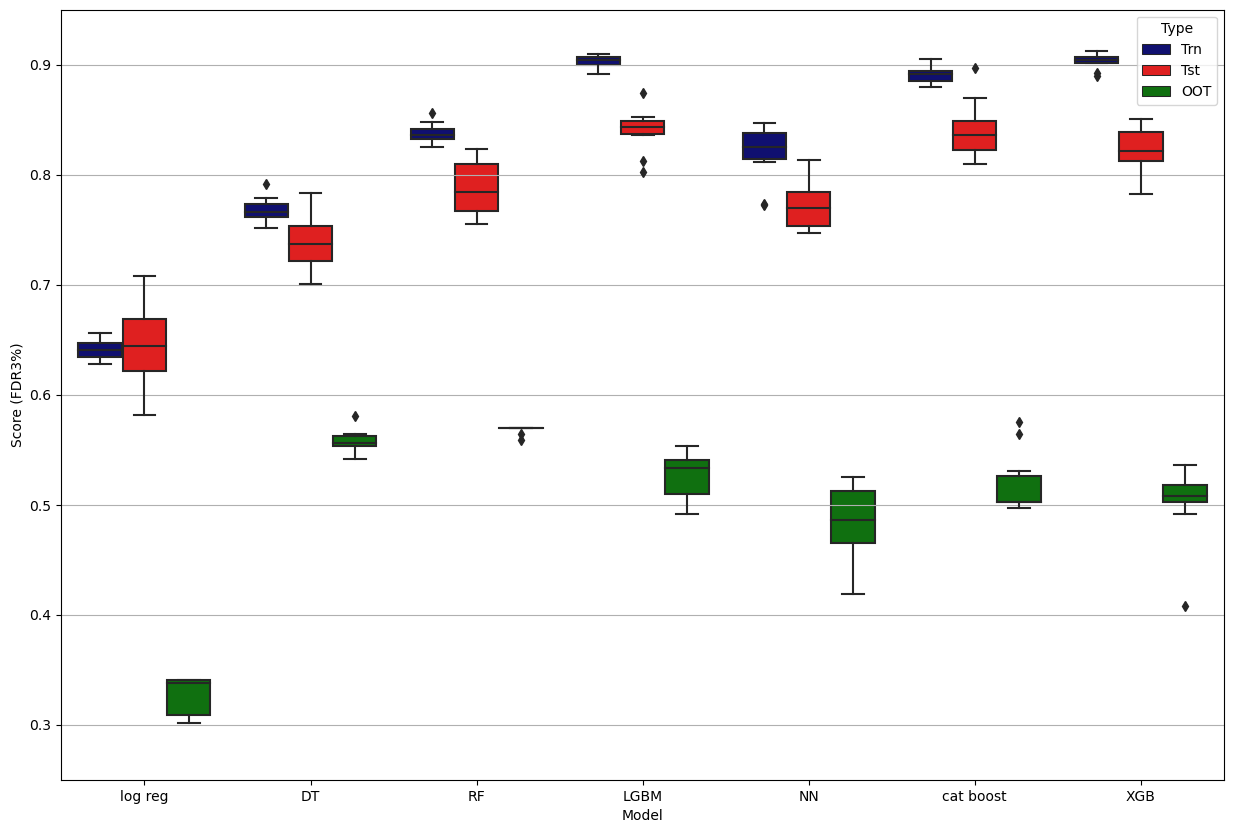

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=best_models_compare, palette=['navy','r','g'])

plt.ylim(.25,0.95)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [53]:
print('duration: ', datetime.now() - start_time)

duration:  0:44:18.617056


0 0.7471264367816092 0.7712177121771218 0.553072625698324
1 0.7845394736842105 0.7536764705882353 0.553072625698324
2 0.7853577371048253 0.7598566308243727 0.4692737430167598
3 0.7781350482315113 0.7635658914728682 0.4748603351955307
4 0.7912621359223301 0.7900763358778626 0.4748603351955307
5 0.8012519561815337 0.7510373443983402 0.5586592178770949
6 0.7886178861788617 0.7509433962264151 0.553072625698324
7 0.7724358974358975 0.69921875 0.4972067039106145
8 0.804635761589404 0.7572463768115942 0.5698324022346368
9 0.792332268370607 0.7755905511811023 0.5027932960893855
loop trn tst oot 10 0.7845694601480789 0.7572429459557911 0.5206703910614525
0 0.7532258064516129 0.7576923076923077 0.553072625698324
1 0.7896494156928213 0.7686832740213523 0.5586592178770949
2 0.7743506493506493 0.7803030303030303 0.553072625698324
3 0.7657232704402516 0.6967213114754098 0.5586592178770949
4 0.7577741407528642 0.7434944237918215 0.553072625698324
5 0.8067226890756303 0.8140350877192982 0.564245810055

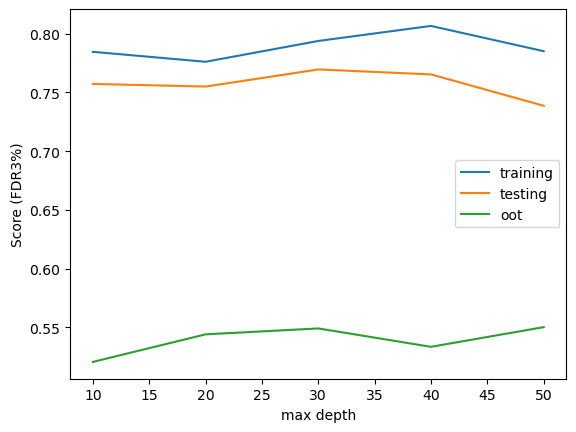

CPU times: user 24min 7s, sys: 49.9 s, total: 24min 57s
Wall time: 3min 17s


In [54]:
%%time
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(10,51,10):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        #model = CatBoostClassifier(verbose=0, iterations=i, learning_rate=0.01, depth=8, l2_leaf_reg=8)

        #model = MLPClassifier(hidden_layer_sizes=i)
        
        #model = lgb.LGBMClassifier(n_estimators=20, num_leaves=i, learning_rate=0.1, max_depth=20, min_child_samples=300)
        
        #model = DecisionTreeClassifier(n_estimators=i)
        
        #model = xgb.XGBClassifier(learning_rate=learning_rate, booster=booster, max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=reg_alpha)
        
        model = xgb.XGBClassifier(learning_rate=0.01, booster='gbtree', max_depth=i, reg_lambda=1, reg_alpha=1)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'max depth': range(10,51,10),'training':training,'testing':testing,'oot':oot})
table.set_index('max depth',inplace=True) 
table.plot()
#plt.savefig('complexity_decisiontree.pdf', format='pdf')
plt.xlabel('max depth')
plt.ylabel('Score (FDR3%)')
plt.show()

In [55]:
table

,training,testing,oot
max depth,,,
10,0.784569,0.757243,0.520670
20,0.776092,0.754993,0.544134
30,0.793798,0.769571,0.549162
40,0.806601,0.765325,0.533520
50,0.785096,0.738623,0.550279


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [56]:
%%time

FDR3 = pd.DataFrame(np.zeros((100,3)), columns=('trn', 'tst', 'oot'))

for niter in range(100):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    #model = MLPClassifier()

    model = CatBoostClassifier(verbose=0, iterations=500, learning_rate=0.01, depth=8, l2_leaf_reg=8)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR3.loc[niter, 'oot'] > .55): break
    
model_counter = model_counter + 1

0 0.8288431061806656 0.8032128514056225 0.5586592178770949
CPU times: user 17.5 s, sys: 3.35 s, total: 20.8 s
Wall time: 4.32 s


In [57]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [58]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_30,card_state_total_3,Merchnum_desc_total_1,Card_Merchdesc_Zip_max_60,card_state_total_0,Card_Merchdesc_max_60,Card_Merchnum_desc_max_60,Card_Merchnum_Zip_avg_14,Card_Merchnum_Zip_max_60,...,state_des_total_1,Merchnum_desc_State_total_7,Merchnum_desc_total_7,Merchnum_desc_State_total_1,card_zip3_total_60,Card_Merchnum_Zip_total_14,Card_Merchnum_Zip_total_30,Merchnum_desc_State_total_3,predicted,Fraud
89128,7.032080,2.657146,7.122023,5.466522,2.778671,2.604095,2.777283,2.823420,0.955272,2.819909,...,5.369216,3.580803,3.580667,5.466560,5.546657,7.032883,6.783699,4.545510,0.972717,1
89121,6.919599,2.657146,7.008225,5.358689,2.778671,2.426536,2.777283,2.823420,0.990094,2.819909,...,5.263120,3.506375,3.506241,5.358727,5.455233,6.920391,6.674626,4.454413,0.972717,1
89120,6.526025,2.657146,6.610043,4.981379,2.778671,1.805256,2.777283,2.823420,0.966057,2.819909,...,4.891890,3.245953,3.245821,4.981417,5.135342,6.526782,6.292977,4.135663,0.969206,1
89114,6.341724,2.657146,6.423585,4.804694,2.778671,1.514326,2.777283,2.823420,1.055925,2.819909,...,4.718052,3.124003,3.123873,4.804733,4.985545,6.342465,6.114260,3.986401,0.969067,1
89117,6.440934,2.657146,6.523956,4.899804,2.778671,1.670935,2.777283,2.823420,1.010656,2.819909,...,4.811629,3.189649,3.189518,4.899843,5.066181,6.441683,6.210464,4.066749,0.969030,1
89130,9.112749,6.761545,9.227049,7.374708,7.013570,5.888553,7.011174,7.113597,1.242576,7.112089,...,7.246656,4.897852,4.897700,7.374748,7.237796,9.113738,8.801326,6.157538,0.957685,1
89174,9.315547,6.761545,9.432221,7.500554,7.013570,6.208682,7.011174,7.113597,1.161489,7.112089,...,7.370475,4.984713,4.984560,7.500594,7.402627,9.316554,8.997979,6.263853,0.956249,1
89183,9.722158,6.761545,9.843592,7.890362,7.013570,6.850541,7.011174,7.113597,1.176787,7.112089,...,7.754001,5.253762,5.253605,7.890402,7.733114,9.723201,9.392270,6.593161,0.956249,1
89186,9.768772,6.761545,9.890752,7.935050,7.013570,6.924125,7.011174,7.113597,1.131806,7.112089,...,7.797969,5.284606,5.284449,7.935090,7.771002,9.769820,9.437472,6.630913,0.954362,1
89083,5.388330,2.657146,5.459030,4.321856,2.778671,0.009338,2.777283,2.823420,1.038323,2.819909,...,4.242993,2.790743,2.790617,4.321894,4.210640,5.388986,5.189753,3.578501,0.953878,1


In [59]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,52.0,72.0,41.935484,58.064516,124.0,52.0,72.0,0.424559,40.223464,39.798905,0.722222
2,2.0,125.0,102.0,23.0,81.600000,18.400000,249.0,154.0,95.0,1.257348,53.072626,51.815278,1.621053
3,3.0,124.0,119.0,5.0,95.967742,4.032258,373.0,273.0,100.0,2.228935,55.865922,53.636986,2.730000
4,4.0,124.0,121.0,3.0,97.580645,2.419355,497.0,394.0,103.0,3.216852,57.541899,54.325048,3.825243
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,124.0,124.0,0.0,100.000000,0.000000,11930.0,11751.0,179.0,95.942195,100.000000,4.057805,65.648045
97,97.0,124.0,124.0,0.0,100.000000,0.000000,12054.0,11875.0,179.0,96.954605,100.000000,3.045395,66.340782
98,98.0,124.0,124.0,0.0,100.000000,0.000000,12178.0,11999.0,179.0,97.967015,100.000000,2.032985,67.033520
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12303.0,12124.0,179.0,98.987590,100.000000,1.012410,67.731844


Max possible savings: 20,952,000.0


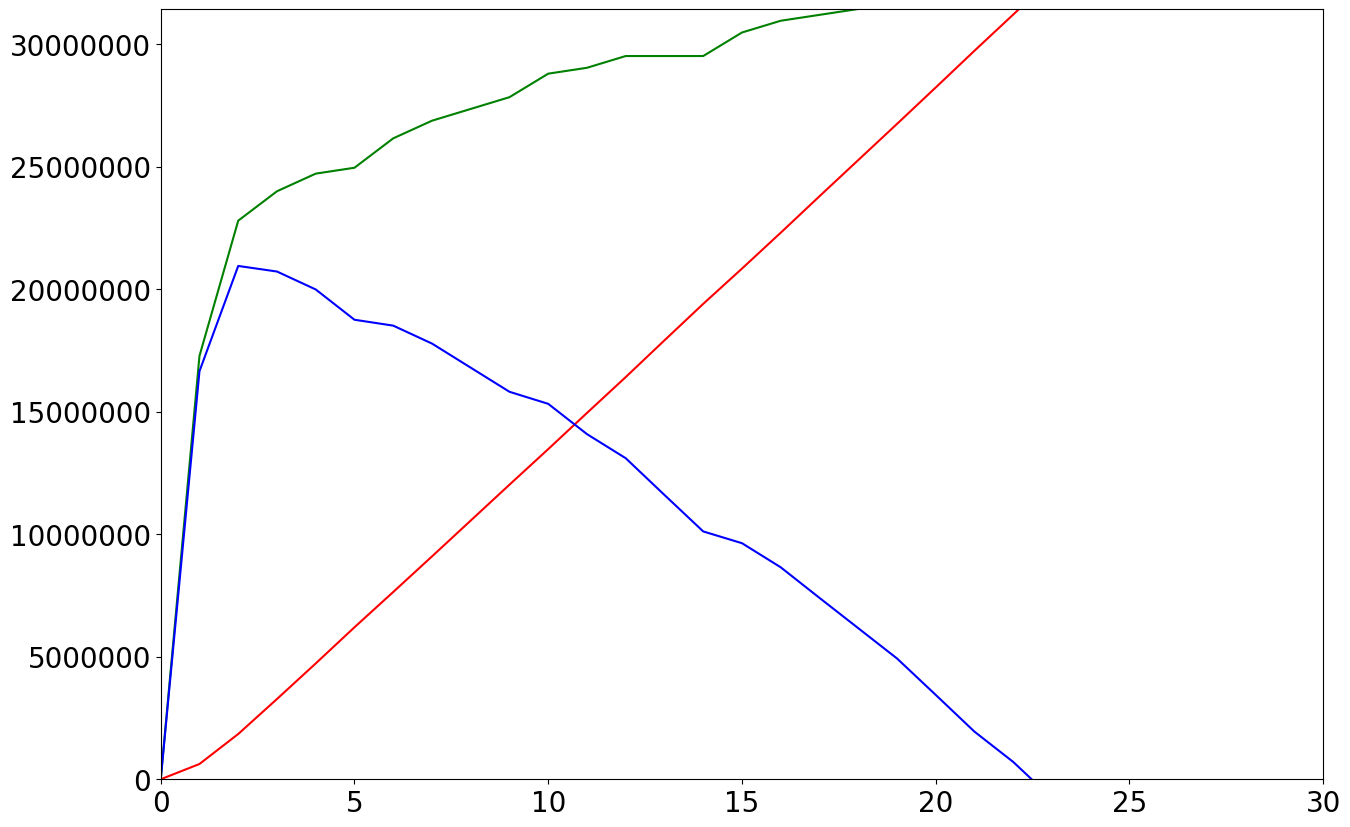

In [60]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [61]:
FDR3.to_csv('FDR3.csv')

In [62]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [63]:
print("duration: ", datetime.now() - start_time)

duration:  0:47:41.548568


In [64]:
%pwd

'/Users/ananshar/Desktop/Work/Projects/Fraud Detection'

In [65]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 147 ms, sys: 14.3 ms, total: 162 ms
Wall time: 164 ms


(96397, 10)

In [66]:
df['prediction'] = model.predict_proba(X)[:,1]

In [67]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [68]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000754
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.001144
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.001019
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000754
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000750


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           93199 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        95377 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  prediction         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.8+ MB


In [70]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
36025,36026,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1332.17,1,1.000000
36015,36016,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1429.25,1,1.000000
36013,36014,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1020.96,1,1.000000
35988,35989,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1092.55,1,1.000000
35944,35945,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1358.07,1,0.999541
35910,35911,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,2116.52,1,0.999541
35923,35924,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1005.72,1,0.999541
35908,35909,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,2126.62,1,0.999276
35900,35901,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,2715.98,1,0.999221
50724,50725,5142176939,2010-07-05,4503082476300,OFFICE DEPOT #1082,MD,20763.0,P,1332.41,1,0.999018


In [71]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

5142140316    46
5142847398    45
5142199009    45
5142160778    41
5142189341    41
5142181728    39
5142212038    39
5142220919    38
5142214614    37
5142202847    37
5142138135    36
5142271065    34
5142152857    32
5142179617    32
5142235211    32
5142197711    32
5142182128    31
5142189113    30
5142197563    30
5142116864    28
Name: Cardnum, dtype: int64

In [72]:
bads['Merchnum'].value_counts().head(15)

4353000719908    107
930090121224      50
8834000695423     46
4503738417400     45
4620009957157     39
618901687330      36
900009045549      36
9108234610000     33
253052983001      33
938909877224      32
4503082476300     31
6006333528866     30
997674930332      29
6070095870009     27
9900020006406     25
Name: Merchnum, dtype: int64

In [73]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

107

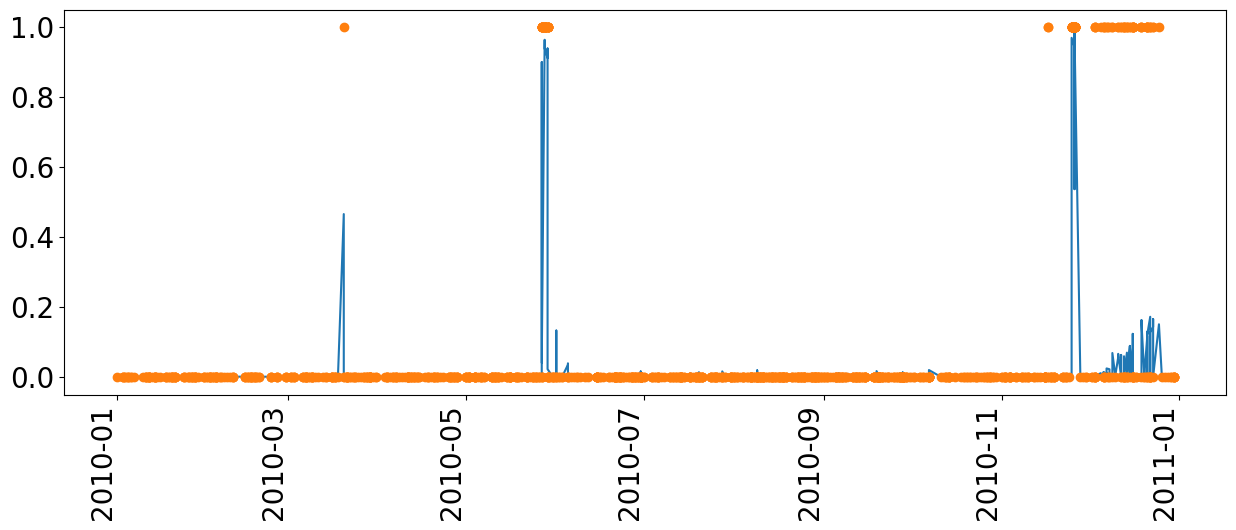

In [74]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [75]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,86387,86388,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.001311
1,2,86406,86407,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001539
2,3,86485,86486,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001013
3,4,86802,86803,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000720
4,5,86907,86908,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000784


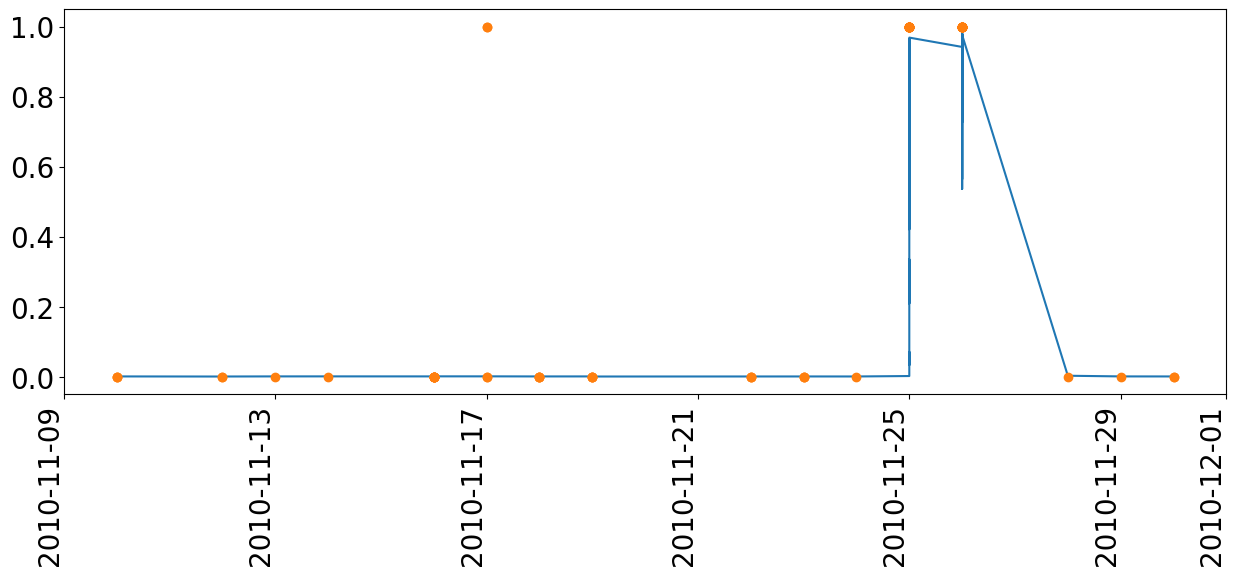

In [76]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

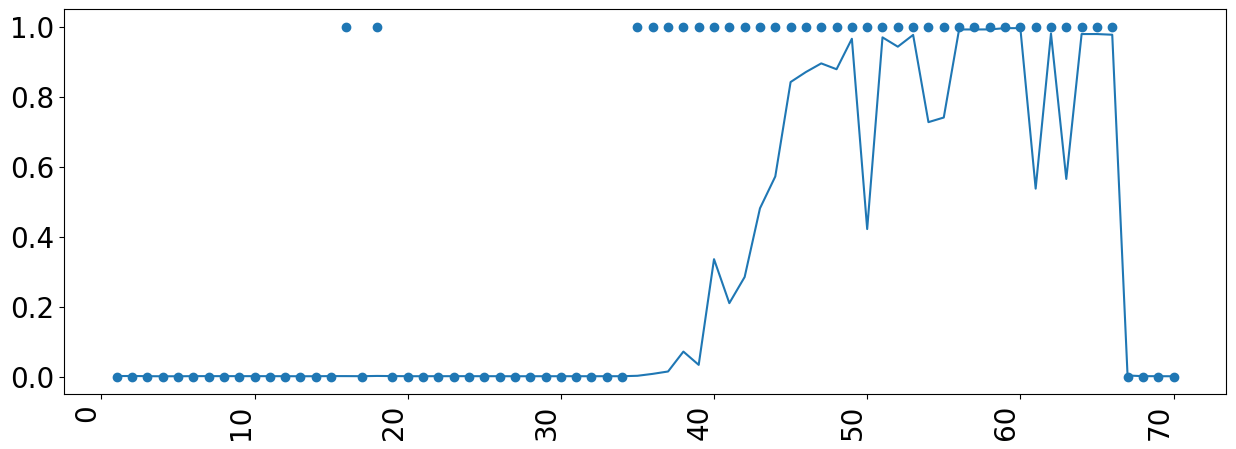

In [77]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [78]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,86387,86388,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.001311
1,2,86406,86407,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001539
2,3,86485,86486,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001013
3,4,86802,86803,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000720
4,5,86907,86908,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000784
5,6,86984,86985,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.001087
6,7,87000,87001,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.001145
7,8,87282,87283,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.001078
8,9,87317,87318,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.001085
9,10,87415,87416,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.001064


In [79]:
print("duration: ", datetime.now() - start_time)

duration:  0:47:42.240745
